In [8]:
import os
import cv2
import image_operations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
import joblib

classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
base_dir = ''

all_image_paths = []

# Coleta todos os endereços das imagens
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for image_name in os.listdir(class_dir):
        if image_name.endswith('.png') or image_name.endswith('.jpg'):  # Filtrando por arquivos de imagem
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append(image_path)

# Cria um dicionário de dados para armazenar os valores de Hu, o id e a classe de cada imagem
hu_values = {"id":[],
              "Hu_gray":[],
              "Hu_H":[],
              "Hu_S":[],
              "Hu_V":[],
              "Label":[]}

# Preenche os dados do dicionário para todas as imagens do dataset
for image in all_image_paths:
    hu_gray, hu_h, hu_s, hu_v = image_operations.get_hu_moments_model_bin(cv2.imread(image))
    image_split = image.split("\\")
    image_label = image_split[0]
    image_id = image_split[1].split(".")[0]
    hu_values["id"].append(image_id)
    hu_values["Hu_gray"].append(hu_gray)
    hu_values["Hu_H"].append(hu_h)
    hu_values["Hu_S"].append(hu_s)
    hu_values["Hu_V"].append(hu_v)
    hu_values["Label"].append(image_label)
    
# Formata os dados separando cada valor de Hu em uma coluna diferente
df_model_bin = pd.DataFrame(hu_values)
for col in [i for i in df_model_bin.columns if "Hu" in i]:
    n_cols = [col+str(j) for j in range(1, 8)]
    df_model_bin[n_cols] = df_model_bin[col].tolist()
    df_model_bin = df_model_bin.drop(columns=col)

df_model_bin = df_model_bin.set_index("id")

df_model_bin["Label"] = np.where(df_model_bin["Label"]=="Negative for intraepithelial lesion","0","1")

# Randomiza a ordem dos dados e os separa em treino e teste com a proporção 4:1
X = df_model_bin.drop(columns="Label")
y = df_model_bin["Label"]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
X, y, test_size=0.2, random_state=674310)

# Mostra a disposição dos dados
X_train_bin.describe()

,Hu_gray1,Hu_gray2,Hu_gray3,Hu_gray4,Hu_gray5,Hu_gray6,Hu_gray7,Hu_H1,Hu_H2,Hu_H3,...,Hu_S5,Hu_S6,Hu_S7,Hu_V1,Hu_V2,Hu_V3,Hu_V4,Hu_V5,Hu_V6,Hu_V7
count,9227.000000,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9227.000000,9.227000e+03,9.227000e+03,...,9.227000e+03,9.227000e+03,9.227000e+03,9227.000000,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03,9.227000e+03
mean,0.001148,2.457697e-06,6.467045e-08,4.160316e-08,3.637540e-12,1.556000e-09,5.258380e-14,0.002922,1.558977e-08,6.967879e-11,...,1.085356e-11,1.808539e-09,-2.159013e-12,0.000801,2.013677e-07,2.059119e-09,1.634041e-09,4.418982e-15,2.380742e-11,-4.683361e-16
std,0.001982,6.173287e-05,2.701690e-06,1.913475e-06,3.130398e-10,9.814966e-08,4.359272e-12,0.000498,2.438934e-08,1.161556e-10,...,9.917569e-10,1.456800e-07,2.296065e-10,0.000662,1.077534e-05,9.672147e-08,7.610305e-08,4.967638e-13,2.133881e-09,6.628625e-14
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-5.078314e-12,-7.079343e-08,-1.039056e-11,0.001928,3.641856e-13,7.233503e-16,...,-2.545728e-15,-2.097860e-10,-2.199642e-08,0.000649,0.000000e+00,0.000000e+00,0.000000e+00,-6.542401e-12,-6.755991e-09,-5.964844e-12
25%,0.000699,1.120984e-11,5.236003e-15,3.499836e-14,-4.991020e-25,-5.021772e-17,-1.626658e-25,0.002468,2.447930e-09,9.849209e-12,...,-3.394736e-24,-1.181636e-16,-1.834147e-23,0.000654,5.181054e-17,1.391400e-21,1.362795e-18,-1.186629e-27,-8.851727e-19,-2.546476e-29
50%,0.000766,9.306776e-10,9.467488e-13,5.670430e-13,-7.906483e-30,-1.122820e-19,0.000000e+00,0.002959,7.267584e-09,3.103850e-11,...,2.870934e-28,-2.087995e-23,0.000000e+00,0.000675,1.024373e-11,6.746858e-15,1.317896e-14,0.000000e+00,-7.118145e-23,0.000000e+00
75%,0.000997,1.558942e-08,2.215872e-11,1.152237e-11,2.873086e-26,1.421015e-20,1.158291e-25,0.003314,1.888687e-08,8.356331e-11,...,1.208612e-22,1.184000e-15,2.228742e-23,0.000740,8.709576e-10,1.027697e-12,4.634437e-13,1.806739e-33,0.000000e+00,2.562041e-29
max,0.070471,4.444252e-03,1.819756e-04,1.718044e-04,2.997707e-08,8.638518e-06,4.151979e-10,0.004498,5.945047e-07,3.060905e-09,...,9.517190e-08,1.386675e-05,1.497438e-09,0.033701,1.016989e-03,8.302994e-06,6.458876e-06,4.725792e-11,2.045617e-07,1.972978e-12


In [9]:
# Mostra a proporção dos valores das classes
print(y_train_bin.value_counts(), y_test_bin.value_counts())

Label
0    5416
1    3811
Name: count, dtype: int64 Label
0    1363
1     944
Name: count, dtype: int64


In [10]:
# Treina o modelo aplicando um balanceamento automatico no peso das classes
svm_bin = SVC(class_weight='balanced', C=10, kernel='rbf', gamma='scale')
svm_bin.fit(X_train_bin, y_train_bin)

SVC(C=10, class_weight='balanced')

0.7633289986996099


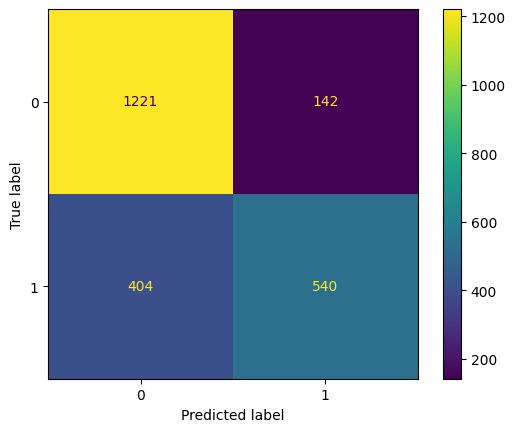

In [11]:
# Gera a matriz de confusão e a acurácia do modelo
ConfusionMatrixDisplay(confusion_matrix(y_test_bin, svm_bin.predict(X_test_bin))).plot()
y_pred = svm_bin.predict(X_test_bin)
print(accuracy_score(y_test_bin, y_pred))

In [12]:
# Armazena o variável do modelo em um arquivo para ser acessado pela interface
joblib_file = "modelo_raso_binario.pkl"
joblib.dump(svm_bin, joblib_file)

['modelo_raso_binario.pkl']